In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Image Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load good

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('/content/drive/MyDrive/indas/004_OK/') if isfile(join('/content/drive/MyDrive/indas/004_OK/', f))]

In [ ]:
# in my direction is one other file... -> delete from list
del onlyfiles[999]

In [ ]:
my_path = '/content/drive/MyDrive/indas/004_OK/'
image_list_train = [cv2.imread( my_path + img_name, cv2.IMREAD_REDUCED_GRAYSCALE_4).astype('float32') / 255. for  img_name in  onlyfiles]
# image_list_test = [cv2.imread( my_path + img_name, cv2.IMREAD_REDUCED_GRAYSCALE_4).astype('float32') / 255. for  img_name in  onlyfiles[400: 500]]

Create an array of images. I permute the order and afterwards take the first 900 from the 1000 images as train and the last 100 as test. 

In [ ]:
image_array = np.array(image_list_train)
image_array = image_array[np.random.permutation(range(1000)), :, :]

#### Load the anomaly images

In [ ]:
onlyfiles_test = [f for f in listdir('/content/drive/MyDrive/indas/004_NOK/') if isfile(join('/content/drive/MyDrive/indas/004_NOK/', f))]

In [ ]:
my_path_test = '/content/drive/MyDrive/indas/004_NOK/'
image_list_test = [cv2.imread( my_path_test + img_name, cv2.IMREAD_REDUCED_GRAYSCALE_4).astype('float32') / 255. for  img_name in  onlyfiles_test]
# image_list_test = [cv2.imread( my_path + img_name, cv2.IMREAD_REDUCED_GRAYSCALE_4).astype('float32') / 255. for  img_name in  onlyfiles[400: 500]]

Not all pictures of angle 004 in the NOK directory contain pictures of the fail. So i create a bool index of the fail pictures

In [ ]:
True_anomalies = np.array(['FAIL' in string for string in onlyfiles_test])

In [ ]:
image_array_anomal = np.array(image_list_test)

## Train the PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import seaborn as sns

Just create a principal component decomposition of the images with a real high number of components - this is bounded by the number of observed images.

For the pca, we need a flat array, each pixel is one feature / column and each image is one row.  

In [ ]:
pca = PCA(n_components=700)
pca.fit(image_array[0:900, :, :].reshape(900, 504*504))

PCA(n_components=700)

### Reconstruct Images

The reconstruction of the images is done in two steps:
- transform: that project the images on the space of the principal components
- inverse_transform: that project from the space of principal components back to the space of images

#### Reconstruction of the train images

For inspect the power of the method, first a short glimpse at the results on the train images

In [ ]:
pca_transformed_train = pca.transform(image_array[0:900,:,:].reshape(900, 504*504))
pca_reverse_transformed_train = pca.inverse_transform(pca_transformed_train)

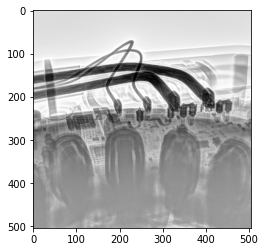

In [ ]:
plt.imshow(image_array[1, :, :], cmap = 'gray')

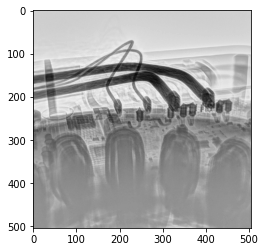

In [ ]:
plt.imshow(pca_reverse_transformed_train[1, :].reshape((504, 504)), cmap = 'gray')

That looks incredible  good!

#### Inspect the power on the Test-good

In [ ]:
pca_transformed_test_good = pca.transform(image_array[900:1000,:,:].reshape(100, 504*504))
pca_reverse_transformed_test_good = pca.inverse_transform(pca_transformed_test_good)

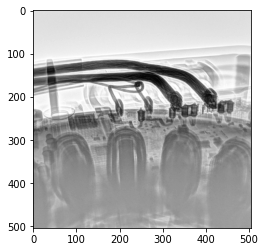

In [ ]:
plt.imshow(image_array[901, :, :], cmap = 'gray')

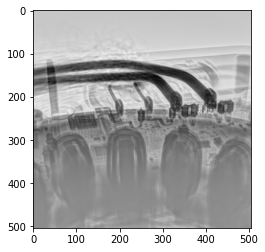

In [ ]:
plt.imshow(pca_reverse_transformed_test_good[1, :].reshape((504, 504)), cmap = 'gray')

That also looks very good - there is a problem with the wires... 

#### Inspect Power on Anomal images

In [ ]:
pca_transformed_anomal = pca.transform(image_array_anomal.reshape(464, 504*504))
pca_reverse_transformed_anomal = pca.inverse_transform(pca_transformed_anomal)

Below an impresive example for a very big anomaly. 

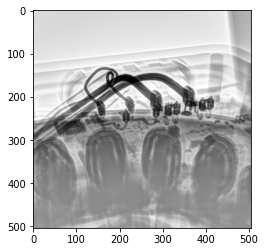

In [ ]:
plt.imshow(image_array_anomal[2,:,:], cmap = 'gray')

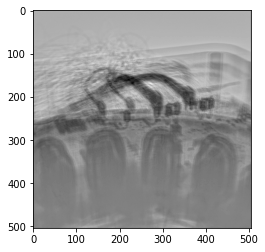

In [ ]:
plt.imshow(pca_reverse_transformed_anomal[2, :].reshape((504, 504)), cmap = 'gray')

In the reconstruction is a lot more noise, but the anomaly was not reconstructed!!! Below you see the errormap. There are big errors by reconstruct the wires, but the anomaly is also very obvious!

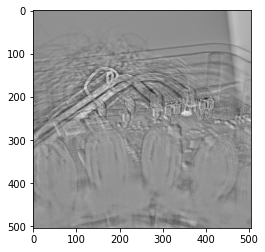

In [ ]:
plt.imshow(-image_array_anomal[2,:,:] + pca_reverse_transformed_anomal[2, :].reshape((504, 504)), cmap = 'gray')

#### Compare error distributions

First take a look at the distribution of the sum of abs errors

In [ ]:
SAE_good = np.abs(
    (pca_reverse_transformed_test_good - image_array[900:1000, :, :].reshape(100, 504*504)
    )).sum(axis = 1)

In [ ]:
SAE_anomal = np.abs(
    (pca_reverse_transformed_anomal - image_array_anomal.reshape(464, 504*504)
    )).sum(axis = 1)

TypeError: ignored

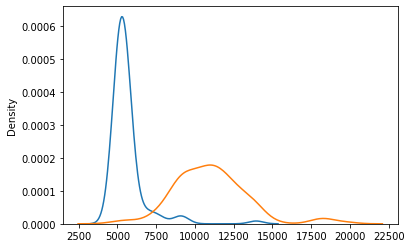

In [ ]:
sns.kdeplot(SAE_good) + sns.kdeplot(SAE_anomal)

In [ ]:
np.quantile(SAE_good, .95)

7671.488793945312

In [ ]:
np.quantile(SAE_anomal, .05)

7632.27294921875

That is very very good! The smaller 95% of error sums of the good images are a lot smaller that the smaller 5% of the anomal images. That means, we could achieve a sensitivity of over 95% by a specifity of over 95%!

#### Try to leverage the differnces

There are like i few simple logical rules to get more out of the differences:
- The original image has to be darker for being a solder ball! Here would be a simple approach, just to take those errors. 
- In Areas where a big variance appear, the errors can be weighted less -like in the area around the wires. Here would be a simple approach, just to divide by the standard deviation. The problem in that is, that there are areas with very small varance, so a very small difference would get very big. 


In [ ]:
Standard_Error_arr_train = (image_array[0:900,:,:].reshape(900, 504*504) - pca_reverse_transformed_train).std(axis = 0)

Adding a lower boundary, so that small errors dont get ridicolous big. Boundary 3/255 -> 1 / (3/255) = 85 -> upper boundary for the corrected errors. 

Changed to 2/255

In [ ]:
SE_arr_train_adj = np.maximum(Standard_Error_arr_train, 2/255)

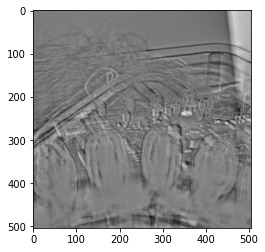

In [ ]:
plt.imshow((- image_array_anomal[2,:,:]  + pca_reverse_transformed_anomal[2, :].reshape((504, 504)))/SE_arr_train_adj.reshape((504, 504)) / 128, cmap = 'gray')

The effect in the area of the wires is nice - but the effect in the upper right area is not so good.... 

Function for calculating the adjusted error. For that important: bright means number near 1. we are only interested in the areas, where the original image is darker than the reconstructed one. Then we scale by something like an lower bounded standard deviation. At the end just give back where the result is bigger than a predefined threshold. 0.2 was just a very quick try. 

In [ ]:
def calculateErrorMap(image, reconstructed, thresh = 0.2):
  error = np.maximum((reconstructed.reshape((1, 504*504)) - image.reshape((1, 504*504))), np.zeros((1, 504*504)))
  error = (error / SE_arr_train_adj).reshape((504, 504)) / 128
  error[error < thresh] = 0
  return (error)


### Inspect leveraged errormap 

#### First big anomaly

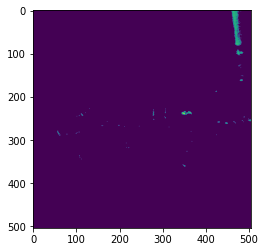

In [ ]:
plt.imshow(calculateErrorMap(image_array_anomal[2,:,:], pca_reverse_transformed_anomal[2, :])) 

Now create an overlay by hand.

In [ ]:
alpha_images_an2 = np.concatenate([np.repeat(image_array_anomal[2,:,:], 3).reshape((504, 504,3)), 0.7*np.ones((504, 504, 1))], axis = 2)

In [ ]:
error_map_an2 = np.concatenate([np.ones((504, 504, 1)), 1-10*np.repeat(calculateErrorMap(image_array_anomal[2,:,:], pca_reverse_transformed_anomal[2, :])[:,:, None], 2, axis = 2), np.ones((504, 504, 1))], axis =2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


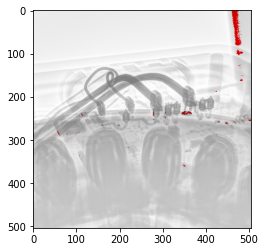

In [ ]:
plt.imshow((error_map_an2 * 0.5 + alpha_images_an2 * 0.5)[:,:,0:3])

as a first and simple try, that might be helpful for a human. A human knows, that upper right isnt an error.

#### Now a small anomaly i just didnt find

In [ ]:
alpha_images_an1 = np.concatenate([np.repeat(image_array_anomal[1,:,:], 3).reshape((504, 504,3)), 0.7*np.ones((504, 504, 1))], axis = 2)

In [ ]:
error_map_an1 = np.concatenate([np.ones((504, 504, 1)), 1-10*np.repeat(calculateErrorMap(image_array_anomal[1,:,:], pca_reverse_transformed_anomal[1, :])[:,:, None], 2, axis = 2), np.ones((504, 504, 1))], axis =2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


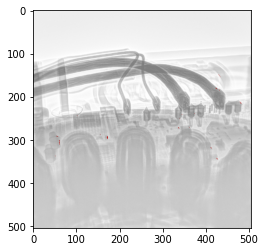

In [ ]:
plt.imshow((error_map_an1 * 0.5 + alpha_images_an1 * 0.5)[:,:,0:3])

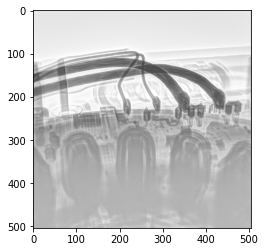

In [ ]:
plt.imshow(alpha_images_an1)

Thats a way more impressive!!!

#### Now the next one

In [ ]:
alpha_images_an8 = np.concatenate([np.repeat(image_array_anomal[8,:,:], 3).reshape((504, 504,3)), 0.7*np.ones((504, 504, 1))], axis = 2)

In [ ]:
error_map_an8 = np.concatenate([np.ones((504, 504, 1)), 1-10*np.repeat(calculateErrorMap(image_array_anomal[8,:,:], pca_reverse_transformed_anomal[8, :])[:,:, None], 2, axis = 2), np.ones((504, 504, 1))], axis =2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


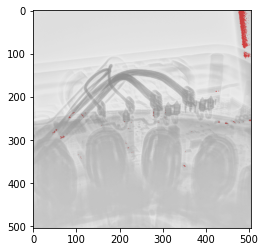

In [ ]:
plt.imshow(error_map_an8 * 0.4 + alpha_images_an8 * 0.5)

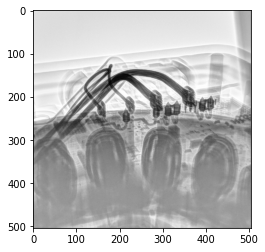

In [ ]:
plt.imshow(alpha_images_an8[:,:, 0:3])

Just dont now.....

In [ ]:
# np.array([i for i in range(464)])[True_anomalies]

In [ ]:
SE_Anom_adj = [calculateErrorMap(image_array_anomal[ind,:,:], pca_reverse_transformed_anomal[ind, :]).sum() for ind in  np.array([i for i in range(464)])[True_anomalies]]

In [ ]:
SE_Good_adj = [calculateErrorMap(image_array[900 + ind,:,:], pca_reverse_transformed_test_good[ind, :]).sum() for ind in  range(100)]

In [ ]:
sns.kdeplot(SE_Anom_adj) + sns.kdeplot(SE_Good_adj)

NameError: ignored

So that may have to be a two step procedure:

- 1. diecide by errorsum, whether its anomal
- 2. build the errormap based on some kind of adjustment and filtering